In [20]:
import pandas as pd

# Load the log file
log_path = '../data/HDFS_100k.log_structured.csv'
df = pd.read_csv(log_path)

# Show basic structure
print("Columns:", df.columns)
print("Shape:", df.shape)
df.head()


Columns: Index(['LineId', 'Date', 'Time', 'Pid', 'Level', 'Component', 'Content',
       'EventId', 'EventTemplate'],
      dtype='object')
Shape: (104815, 9)


,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating


In [ ]:
import datetime
import datetime

# Merge Date and Time columns into one datetime object
df['Timestamp'] = pd.to_datetime(
    df['Date'].astype(str) + df['Time'].astype(str).str.zfill(6),
    format='%y%m%d%H%M%S'
)

# Drop unnecessary columns
df.drop(columns=['LineId', 'Date', 'Time', 'Pid'], inplace=True)

# Sort logs by timestamp
df.sort_values(by='Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

# Preview
df.head()


,Level,Component,Content,EventId,EventTemplate,Timestamp
0,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,1981-10-09 20:35:18
1,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>,1981-10-09 20:35:18
2,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E26,BLOCK* NameSystem.addStoredBlock: blockMap upd...,1981-10-09 20:35:19
3,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E26,BLOCK* NameSystem.addStoredBlock: blockMap upd...,1981-10-09 20:35:19
4,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of siz...,E9,Received block <*> of size <*> from /<*>,1981-10-09 20:35:19


In [ ]:
# Break logs into windows of 50 lines
WINDOW_SIZE = 50
log_windows = []

for i in range(0, len(df), WINDOW_SIZE):
    window = df.iloc[i:i + WINDOW_SIZE]
    if len(window) == WINDOW_SIZE:
        log_windows.append(window)

print("Total windows created:", len(log_windows))
print("First window:\n", log_windows[0].head())


Total windows created: 2096
First window:
   Level                     Component  \
0  INFO      dfs.DataNode$DataXceiver   
1  INFO              dfs.FSNamesystem   
2  INFO              dfs.FSNamesystem   
3  INFO              dfs.FSNamesystem   
4  INFO  dfs.DataNode$PacketResponder   

                                             Content EventId  \
0  Receiving block blk_-1608999687919862906 src: ...      E5   
1  BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...     E22   
2  BLOCK* NameSystem.addStoredBlock: blockMap upd...     E26   
3  BLOCK* NameSystem.addStoredBlock: blockMap upd...     E26   
4  Received block blk_-1608999687919862906 of siz...      E9   

                                       EventTemplate           Timestamp  
0           Receiving block <*> src: /<*> dest: /<*> 1981-10-09 20:35:18  
1                BLOCK* NameSystem.allocateBlock:<*> 1981-10-09 20:35:18  
2  BLOCK* NameSystem.addStoredBlock: blockMap upd... 1981-10-09 20:35:19  
3  BLOCK* NameSystem.addS

In [23]:
import numpy as np

# Get all unique EventIds in the dataset
unique_events = sorted(df['EventId'].unique().tolist())
print("Total unique EventIds:", len(unique_events))  # Should be ~28

# Build a lookup to convert EventId to index in feature vector
event_to_index = {event: idx for idx, event in enumerate(unique_events)}

# Convert each window to a frequency vector
window_vectors = []

for window in log_windows:
    vector = np.zeros(len(unique_events))  # start with all zeroes
    for event_id in window['EventId']:
        if event_id in event_to_index:
            vector[event_to_index[event_id]] += 1
    window_vectors.append(vector)

# Convert list to NumPy array
X = np.array(window_vectors)

# Check shape
print("Feature matrix shape:", X.shape)
print("Example vector (first window):", X[0])


Total unique EventIds: 19
Feature matrix shape: (2096, 19)
Example vector (first window): [ 0.  9.  0.  0.  0.  1.  1.  0.  0.  4.  1. 11.  0.  2. 11.  2.  0.  0.
  8.]


In [24]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Initialize model
iso_forest = IsolationForest(
    n_estimators=200,       # Number of trees
    contamination=0.05,     # Expected proportion of anomalies
    random_state=42
)

# Fit model
iso_forest.fit(X)

# Get anomaly scores
scores = iso_forest.decision_function(X)  # higher = more normal
predictions = iso_forest.predict(X)       # 1 = normal, -1 = anomaly

# Count anomalies
num_anomalies = np.sum(predictions == -1)
print(f"Detected anomalies: {num_anomalies}/{len(X)} windows")

# Preview suspicious windows
for i, (pred, score) in enumerate(zip(predictions, scores)):
    if pred == -1:  # anomaly
        print(f"Window {i} → Anomaly score: {score:.4f}")
        print(log_windows[i].head(3))  # show first 3 logs in the window
        print("="*60)


Detected anomalies: 105/2096 windows
Window 0 → Anomaly score: -0.1934
  Level                 Component  \
0  INFO  dfs.DataNode$DataXceiver   
1  INFO          dfs.FSNamesystem   
2  INFO          dfs.FSNamesystem   

                                             Content EventId  \
0  Receiving block blk_-1608999687919862906 src: ...      E5   
1  BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...     E22   
2  BLOCK* NameSystem.addStoredBlock: blockMap upd...     E26   

                                       EventTemplate           Timestamp  
0           Receiving block <*> src: /<*> dest: /<*> 1981-10-09 20:35:18  
1                BLOCK* NameSystem.allocateBlock:<*> 1981-10-09 20:35:18  
2  BLOCK* NameSystem.addStoredBlock: blockMap upd... 1981-10-09 20:35:19  
Window 1 → Anomaly score: -0.2582
   Level                     Component  \
50  INFO      dfs.DataNode$DataXceiver   
51  INFO  dfs.DataNode$PacketResponder   
52  INFO              dfs.FSNamesystem   

                    

In [ ]:
# Create synthetic labels: 95% normal, 5% anomaly
y_labels = np.ones(X.shape[0])
y_labels[predictions == -1] = -1  # Use previous predictions as pseudo-anomalies

# Save
np.save('../data/X.npy', X)
np.save('../data/y.npy', y_labels)


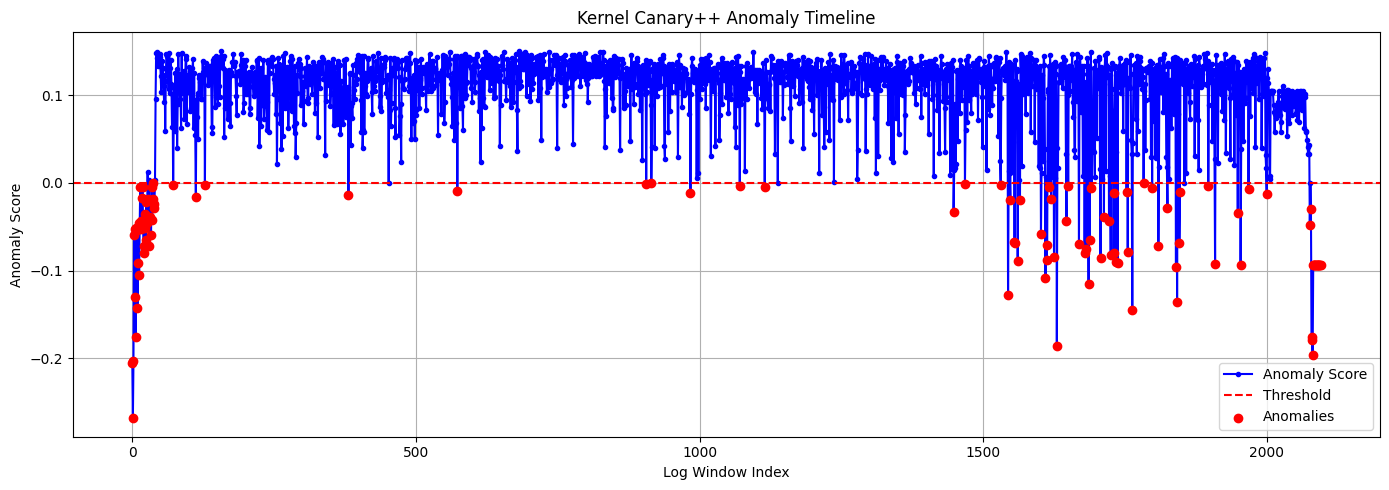

Chart saved to: f:\Kernal Canary\artifacts\anomaly_chart.png


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import json
from pathlib import Path
import os

# Setup paths (works in both Jupyter and .py scripts)
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parent
else:
    ROOT = Path.cwd().parent   # go up one level from /notebooks

# Verify paths
data_path = ROOT / 'data/X.npy'
params_path = ROOT / 'artifacts/best_model_params.json'

if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")
if not params_path.exists():
    raise FileNotFoundError(f"Params file not found: {params_path}")

# Load data
X = np.load(data_path)

# Load best params from NNI
with open(params_path) as f:
    best_params = json.load(f)

# Re-train Isolation Forest with tuned params
model = IsolationForest(
    n_estimators=best_params['n_estimators'],
    contamination=best_params['contamination'],
    random_state=42
)
model.fit(X)

# Score all windows
scores = model.decision_function(X)  # higher = more normal
threshold = np.percentile(scores, best_params['contamination'] * 100)  # dynamic threshold
alerts = scores < threshold  # boolean array for anomalies

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(scores, label='Anomaly Score', color='blue', marker='.')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(np.where(alerts), scores[alerts], color='red', label='Anomalies', zorder=5)

plt.title('Kernel Canary++ Anomaly Timeline')
plt.xlabel('Log Window Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and show
out_path = ROOT / 'artifacts/anomaly_chart.png'
plt.savefig(out_path)
plt.show()

print(f"Chart saved to: {out_path}")


In [27]:
import numpy as np
import json
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

if "__file__" in globals():
    ROOT = Path(__file__).resolve().parent
else:
    ROOT = Path.cwd().parent

# Create pseudo ground truth using baseline model
baseline_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
baseline_model.fit(X)
y_true = baseline_model.predict(X)  # 1 = normal, -1 = anomaly

# Load best model params from NNI
with open(ROOT / "artifacts/best_model_params.json") as f:
    best = json.load(f)

#  Apply tuned model
tuned_model = IsolationForest(
    n_estimators=best["n_estimators"],
    contamination=best["contamination"],
    random_state=42
)
tuned_model.fit(X)
y_pred = tuned_model.predict(X)

# Step 4: Evaluation report
print("Kernel Canary++ Evaluation vs Baseline Labels")
print("-" * 50)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Anomaly", "Normal"], labels=[-1, 1]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred, labels=[-1, 1]))


Kernel Canary++ Evaluation vs Baseline Labels
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.86      0.96      0.91       105
      Normal       1.00      0.99      0.99      1991

    accuracy                           0.99      2096
   macro avg       0.93      0.98      0.95      2096
weighted avg       0.99      0.99      0.99      2096

Confusion Matrix:
[[ 101    4]
 [  16 1975]]


In [28]:
import numpy as np
import joblib
import json
from pathlib import Path
from sklearn.ensemble import IsolationForest

if "__file__" in globals():
    ROOT = Path(__file__).resolve().parent
else:
    ROOT = Path.cwd().parent 
    
X = np.load(ROOT / "data/X.npy")

with open(ROOT / "artifacts/best_model_params.json") as f:
    params = json.load(f)

model = IsolationForest(
    n_estimators=params["n_estimators"],
    contamination=params["contamination"],
    random_state=42
)
model.fit(X)

# Save model
Path("model").mkdir(exist_ok=True)
joblib.dump(model, "model/model.pkl")
print("Model saved.")


Model saved.


In [ ]:
import requests

sample = {
    "window": [0, 0, 2, 1, 0, 0, 0, 1, 0, 4, 0, 11, 0, 2, 11, 2, 0, 0, 8]
}

res = requests.post("http://localhost:5000/score", json=sample)

print("Status code:", res.status_code)
print("Response text:", res.text)

try:
    print("JSON:", res.json())
except Exception as e:
    print("JSON decode failed:", e)


Status code: 200
Response text: {
  "is_anomaly": true
}

JSON: {'is_anomaly': True}


✅ Saved artifacts:
  - f:\Kernal Canary\notebooks\artifacts\event_order.json (length = 19)
  - f:\Kernal Canary\notebooks\artifacts\templates.json (rules = 19)

First 5 EventIds in order: ['E10', 'E11', 'E13', 'E14', 'E15']
Example rule: {'EventId': 'E10', 'Regex': '(?i).*PacketResponder\\s+<\\*>\\s+<\\*>\\s+Exception\\s+<\\*>.*'}


<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mudit\AppData\Local\Temp\ipykernel_5848\3365174912.py:32: SyntaxWarning: invalid escape sequence '\s'
  """
